# Sentiment analysis 

# Introduction
Analyze & classify sentiment of text data, articles into positive or negative

# Objective
Sentiment analysis notebooks dives in very depth of various concepts, methods related to text analysis and understand the meaning of it semantically and/or syntactly. They are classified in the following five based notebooks based on different methods & tools used to analyze & classify text.

1. Sentiment Analysis with Text Blob, Word Cloud, Count Vectorizer, N-Gram
2. Sentiment Analysis using Doc2Vec, N-Gram & Phrase Modelling
3. Sentiment Analysis with Chi2 Square & PCA Dimension Reduction
4. Sentiment Analysis with Keras & Tensorflow
5. Sentiment Analysis with Keras & Tensorflow using Doc2Vec, Pretrained GloVe

# Tres

## 3. Sentiment Analysis with Text Blob, Word Cloud, Count Vectorizer, N-Gram, Zif2 law, Lexical Analysis

In [1]:
# Basic import

import re
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

from gensim.models import Doc2Vec
from gensim.models.doc2vec import LabeledSentence
from gensim.models.phrases import Phrases, Phraser

In [3]:
from textblob import TextBlob
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from datetime import datetime

import multiprocessing

In [4]:
# Read TF dataframe

df = pd.read_hdf('./data/redstone.hdf')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600000 entries, 0 to 1599999
Data columns (total 3 columns):
sentiment        1600000 non-null int64
text             1600000 non-null object
pre_clean_len    1600000 non-null int64
dtypes: int64(2), object(1)
memory usage: 48.8+ MB


,sentiment,text,pre_clean_len
0,0,awww that bummer you shoulda got david carr of...,115
1,0,is upset that he can not update his facebook b...,111
2,0,dived many times for the ball managed to save ...,89
3,0,my whole body feels itchy and like its on fire,47
4,0,no it not behaving at all mad why am here beca...,111


In [5]:
# Santitizing dataframe

df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 3 columns):
sentiment        1600000 non-null int64
text             1600000 non-null object
pre_clean_len    1600000 non-null int64
dtypes: int64(2), object(1)
memory usage: 36.6+ MB


In [6]:
from sklearn import utils
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression

train = df.text
label = df.sentiment
SEED = 21

# Splitting data into train, test & validation sets
x_train, x_val_test, y_train, y_val_test = train_test_split(train, label, test_size=.02, random_state=SEED)

x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size=.5, random_state=SEED)

/home/indiano/miniconda3/envs/tf/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [7]:
# Quantifying the positive & negative sentiments in the dataset

from collections import Counter

counter = Counter(y_train)
print('Train set entries.')
for key in counter:
    if key == 0:
        print('{:.2f}% Negative Entries'.format( (counter[key]/len(y_train))*100 ))
    elif key == 1:
        print('{:.2f}% Positive Entries'.format( (counter[key]/len(y_train))*100 ))
        
counter = Counter(y_val)
print('\nValidation set entries.')
for key in counter:
    if key == 0:
        print('{:.2f}% Negative Entries'.format( (counter[key]/len(y_val))*100 ))
    elif key == 1:
        print('{:.2f}% Positive Entries'.format( (counter[key]/len(y_val))*100 ))

counter = Counter(y_test)
print('\nTest set entries.')
for key in counter:
    if key == 0:
        print('{:.2f}% Negative Entries'.format( (counter[key]/len(y_test))*100 ))
    elif key == 1:
        print('{:.2f}% Positive Entries'.format( (counter[key]/len(y_test))*100 ))

Train set entries.
50.00% Negative Entries
50.00% Positive Entries

Validation set entries.
50.01% Negative Entries
49.99% Positive Entries

Test set entries.
50.21% Negative Entries
49.79% Positive Entries


In [8]:
# Calculate accuracy & summmary of different set of features

def accuracy_features(pipeline, x_train, y_train, x_test, y_test):
    
    counter = Counter(y_test)

    if (counter[0] / (len(y_test)*1.)) > 0.5:
        baseline_accuracy = counter[0] / (len(y_test)*1.)
    else:
        baseline_accuracy = 1. - (counter[0] / (len(y_test)*1.))
   
    # Timer starts
    timer = datetime.now()
    
    model = pipeline.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    
    elapsed_time = datetime.now() - timer
    # Timer stops

    accuracy = accuracy_score(y_test, y_pred)
    
    
    print('Baseline accuracy: {:.2f}%'.format(baseline_accuracy*100))
    print('Accuracy score: {:.2f}%'.format(accuracy*100))
    
    if(accuracy > baseline_accuracy):
        print('\nModel accuracy:{:.2f}% - Baseline accuracy:{:.2f}%: Increase of {:.2f}%'.format(accuracy*100, baseline_accuracy*100, (accuracy-baseline_accuracy)*100))
    else:
        print('Model accuracy:{:.2f}% - Baseline accuracy:{:.2f}%: Decrease of {:.2f}%'.format(accuracy*100, baseline_accuracy*100, (accuracy-baseline_accuracy)*100))
    
    print('Overall Train and Prediction time: {:.2f}s'.format(elapsed_time.total_seconds()))
    print('-'*89)
          
    return accuracy, elapsed_time

In [9]:
# Feature extraction, Iteratively

# Count Vectorizer, Logistic Regression model
cvec = CountVectorizer()
lr = LogisticRegression()

n_features = np.arange(10000, 100001, 10000)

def classical_feature_extraction(vectorizer=cvec, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=lr):
    result = []
    print(classifier)

    for features in n_features:
        # Setting vectorizer parameters & creating pipeline
        cvec.set_params(stop_words=stop_words, max_features=features, ngram_range=ngram_range)
        pipeline = Pipeline([
            ('vectorizer', cvec),
            ('classifier', classifier)
        ])
        print("\nValidation result for {} features".format(features))
        
        # Calculate accuracy & summmary
        features_accuracy, features_time = accuracy_features(pipeline, x_train, y_train, x_val, y_val)
        result.append((features, features_accuracy, features_time))
        
    return result

### TFIDF Vectorizer

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer()

In [17]:
%%time

print('Result for TRIGRAM With STOP words using tfidf\n')
features = classical_feature_extraction(vectorizer=tvec, ngram_range=(1, 3))

Result for TRIGRAM With STOP words using tfidf

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Validation result for 10000 features
Baseline accuracy: 50.01%
Accuracy score: 80.29%

Model accuracy:80.29% - Baseline accuracy:50.01%: Increase of 30.28%
Overall Train and Prediction time: 214.64s
-----------------------------------------------------------------------------------------

Validation result for 20000 features
Baseline accuracy: 50.01%
Accuracy score: 81.25%

Model accuracy:81.25% - Baseline accuracy:50.01%: Increase of 31.24%
Overall Train and Prediction time: 261.76s
-----------------------------------------------------------------------------------------

Validation result for 30000 features
Baseline accuracy: 50.01%
Accuracy score: 81.90%

Model accuracy:81.9

Trigram Features

In [23]:
# Dataframes feature extraction results for without stop words 

fdf = pd.DataFrame(features, columns=['features', 'features_accuracy', 'features_time'])

In [41]:
fdf.to_hdf('./data/tf_trigram_features.hdf', 'tf_trigram_features')

In [13]:
fdf = pd.read_hdf('./data/tf_trigram_features.hdf')
fdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 0 to 9
Data columns (total 3 columns):
features             10 non-null int64
features_accuracy    10 non-null float64
features_time        10 non-null timedelta64[ns]
dtypes: float64(1), int64(1), timedelta64[ns](1)
memory usage: 320.0 bytes


In [10]:
# Vectorize train, validation sets using above dbow_ug_model (Document Bag Of Words Unigram Model)

def vectorize_concate(model1, model2, corpus, size):
    # Numpy zeros initialization
    vectors = np.zeros((len(corpus), size))
    
    for idx, count in zip(corpus.index, range(len(corpus.index))):
        prefix = 'all_' + str(idx)
        # Appending document vectors
        vectors[count] = np.append(model1.docvecs[prefix], model2.docvecs[prefix])

    return vectors

In [11]:
# Load the dbow_ug_model and delete temporary training data

dbow_ug_model = Doc2Vec.load('./data/dbow_ug_model.doc2vec')
dbow_ug_model.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [12]:
# Load the dmm_ug_model and delete temporary training data

dmm_tg_model = Doc2Vec.load('./data/dmm_tg_model.doc2vec')
dmm_tg_model.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [13]:
# Vectorize & concate document vectors of train, validation sets obtained from Distributed Bag Of Words & Distributed Memory 

train_vecs_dbow_dmm = vectorize_concate(dbow_ug_model, dmm_tg_model, x_train, 200)
val_vecs_dbow_dmm = vectorize_concate(dbow_ug_model, dmm_tg_model, x_val, 200)

### Dimensionality Reduction¶

After tring three different methods (Count Vectorizer, TFIDF Vectorizer, DOC2Vec) for feature extraction, the best result on the validation set using classical Logistic Regression classifier (L2 regularization, regularization strength: 1.0) for each of them are as follow.

Populate table with Feature Extractors & it's Accuracy

In [37]:
mydata = [['Count Vectorizer', 80000, [1,2,3], 'Yes', '82.44%'], 
          ['TFIDF Vectorizer', 100000, [1,2,3], 'Yes', '82.92%'],
          ['DOC2VEC', 200, 'Unigram DBOW + Trigram DMM', 'Yes', '75.76%'],
          ['Custom Lexicon Classifier', '-', 'Decision Threshold set to 0.56', '-', '75.96%']]

In [38]:
from tabulate import tabulate
from IPython.display import HTML

display(HTML(tabulate(mydata, headers= ['Feature Extractor', 'No. Of Features', 'N-Gram', 'Stop Words', 'Accuracy'], floatfmt='.6f', tablefmt='html')))

Feature Extractor,No. Of Features,N-Gram,Stop Words,Accuracy
Count Vectorizer,80000,"[1, 2, 3]",Yes,82.44%
TFIDF Vectorizer,100000,"[1, 2, 3]",Yes,82.92%
DOC2VEC,200,Unigram DBOW + Trigram DMM,Yes,75.76%
Custom Lexicon Classifier,-,Decision Threshold set to 0.56,-,75.96%


Apart from the lexical approach, the number of features needed for each model seems quite big. Hence It would be interesting to see how model behaves after reducing dimensions (TFIDF Vectorizer & DOC2VEC) and it would also be easy to do hyperparameter tuning on the reduced features.

The no. of dimensions from Doc2Vec model is 200 (dense matrices with all real numbers), sounds quite small as compared to 100,000 features (sparse matrices with lots of zeros) from TFIDF Vectorizer but the computation time for Doc2Vec is not so small.

#### TFIDF Dimensionality reduction with chi-squared feature selection.



#### Chi2 Feature Selection

In Sklearn, there are three methods you can use for feature selection with sparse matrices such as Tfidf vectors or count vectors. 

Feature selection in Sklearn

1.1) Removing features with low variance : VarianceThreshold

1.2) Univariate feature selection 

Scoring functions           
For regression: f_regression, mutual_info_regression      
For classification: chi2, f_classif, mutual_info_classif

Feature selection with sparse data

If you use sparse data (i.e. data represented as sparse matrices), chi2, mutual_info_regression, mutual_info_classif will deal with the data without making it dense.

1.3) Recursive feature elimination

1.4) Feature selection using SelectFromModel
    
    1.4.1.1) L1-based feature selection
    1.4.1.2) L1-recovery and compressive sensing

    1.4.2) Tree-based feature selection

1.5) Feature selection as part of a pipeline

In my case, I have 1.5 million tweets and want to reduce dimensions from 100,000 features, hence transforming tweets into dense matrices is not an option as it will not fit on my RAM.

The Chi-squared statistic measures the lack of independence between a feature (in this case, one term within a tweet) and class (whether the tweets are positive or negative).

You can first think of the relationship between a term within a tweet and it's class in terms of a contingency table. The contingency table is just a fancy word for a table that displays frequency distribution.

#### Chi2 Feature selection Example with beloved dogs

Let's say we have three sentences in our tweet corpus as below.

1) I love dogs              
2) I hate dogs                  
3) I love dogs and cooking

Defining the sentiment class of each of the above tweet 

In [66]:
mydata = [["'dogs' occur", '2 (A)', '0 (B)'], 
          ["'dogs' doesn't occur", '2 (A)', '0 (B)']]

In [67]:
HTML(tabulate(mydata, headers= ['', 'Positive Class', 'Negative Class'], tablefmt='html'))

,Positive Class,Negative Class
'dogs' occur,2 (A),0 (B)
'dogs' doesn't occur,2 (A),0 (B)


Let's look for a specific term, in this case beloved 'dogs' as 't' and class as 'c' (Positive or Negative). Using contingency table, where A is the number of times 't' occurs and 'c' is positive; B is the number of times 't' occurs and 'c' is negative; C is the number of times 't' doesn't occur and 'c' is positive; finally D is the number of times 't' doesn't occur and 'c' is negative. 

Now we are ready to calculate Chi-squared statistic.

$${\chi}^2(t,c) = \frac {{N}\times{(AD-CB)}^2}{(A+C)\times(B+D)\times(A+B)\times(C+D)}$$

Where N is the total number of samples.

Chi2 score for term "dogs" is 3. As Chi2 square measures the lack of independence between a feature and it's class, hence if a feature has high chi-squared score compared to other features then that feature exhibits important predictive power for the class.

Let's first transform the train data into TFIDF vectors of 100,000 features and reduce dimensions using chi2square.

In [20]:
from sklearn.feature_selection import SelectKBest, chi2

In [22]:
tvec = TfidfVectorizer(max_features=100000, ngram_range=(1, 3))

tf_train, tf_val = tvec.fit_transform(x_train), tvec.transform(x_val)

In [18]:
# Fitting Chi2

chi2score = chi2(tf_train, y_train)[0]

In [30]:
chi2score.size

100000

In [20]:
# Dumping chi2score

import pickle

with open('./data/chi2score.pkl', 'wb') as file:
    pickle.dump(chi2score, file)

Text(0,0.5,'Features')

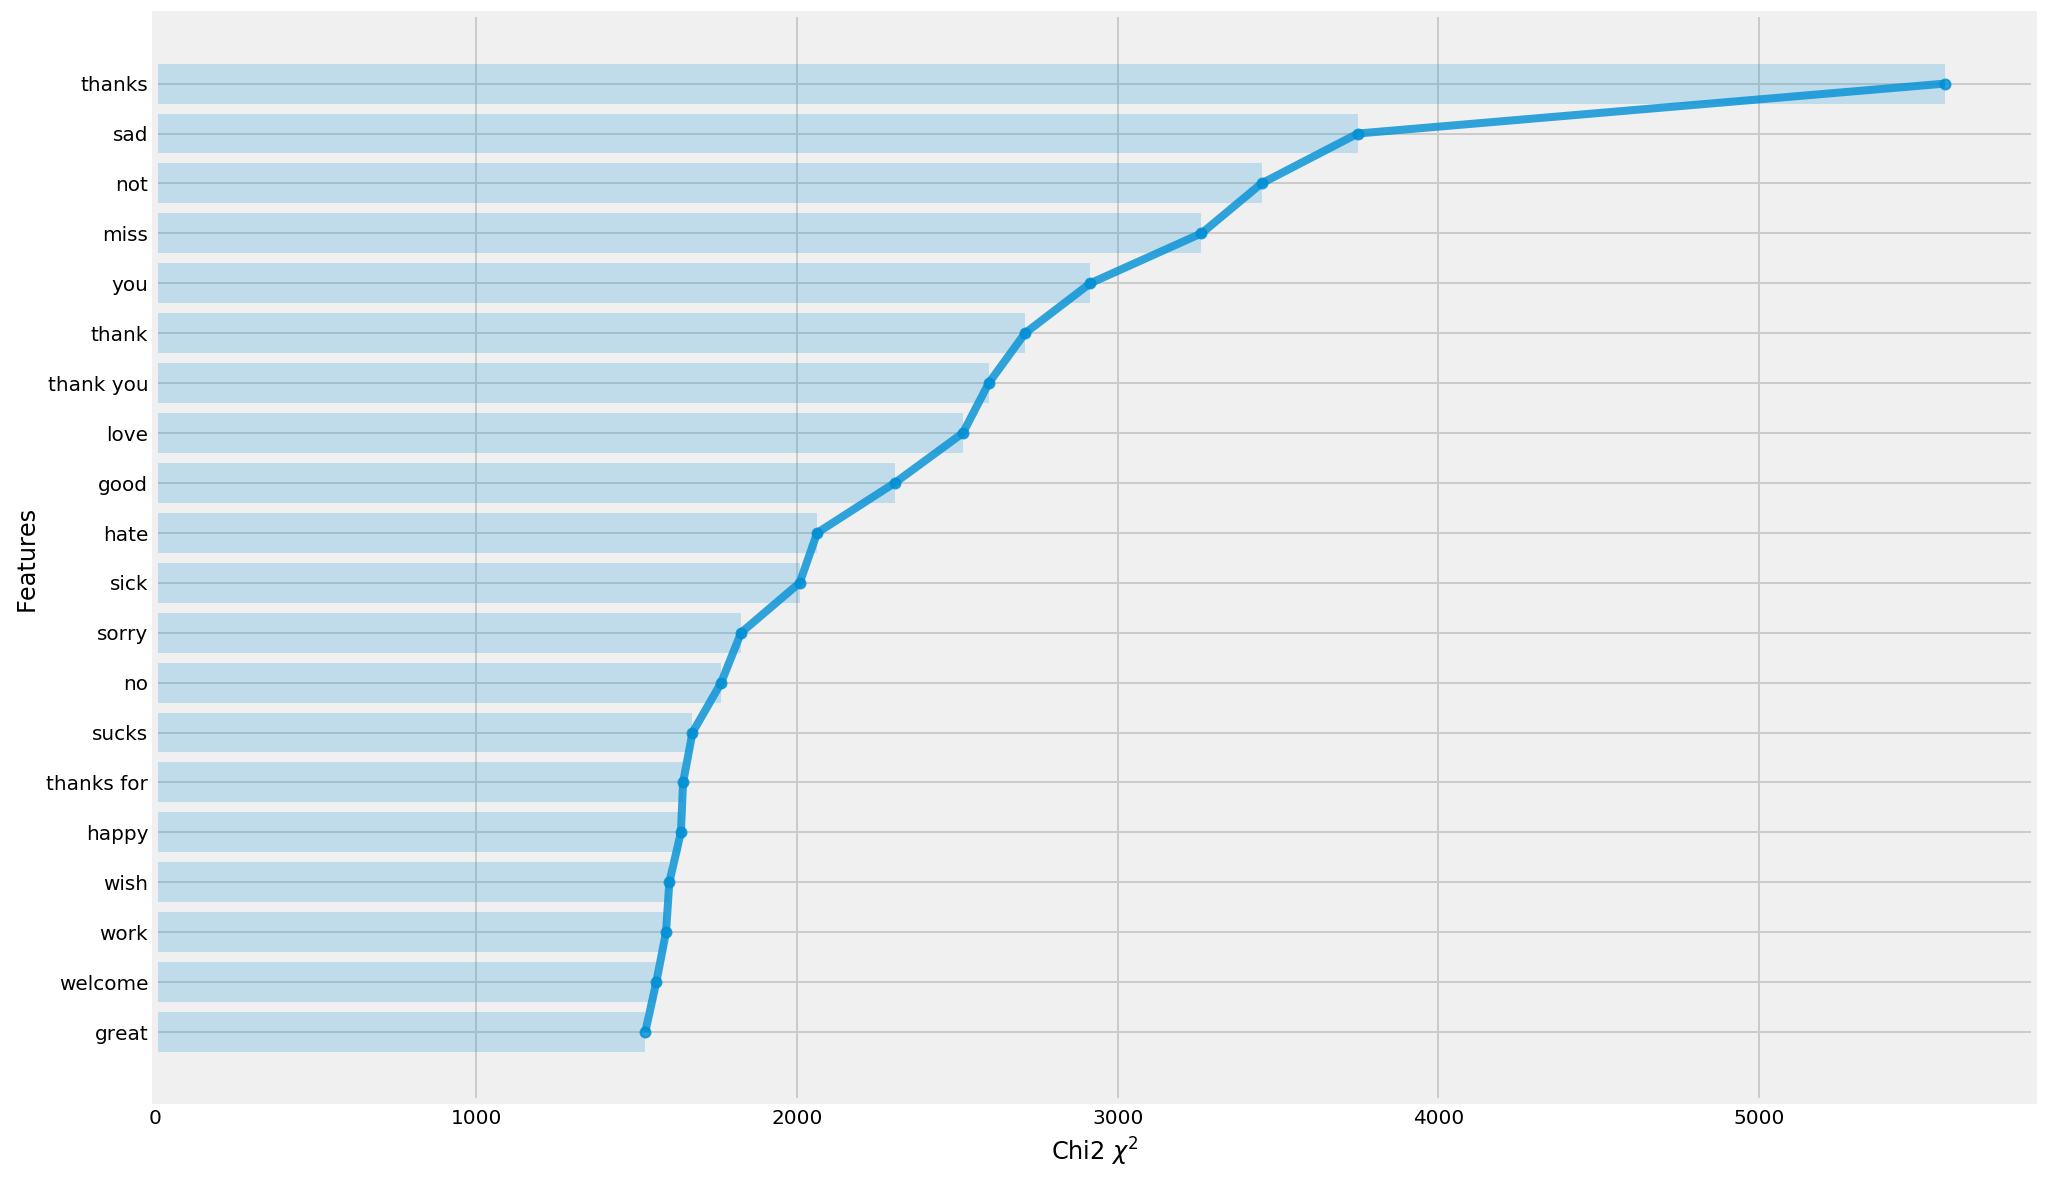

In [28]:
# Plot Important chi2square features after reducing dimesions

plt.figure(figsize=(15,10))

# Zip features names alongwith their scores & sort by chi2 score
features_chi2scores = zip(tvec.get_feature_names(), chi2score)
features_chi2scores_sorted = sorted(features_chi2scores, key=lambda x:x[1])

# Top 20 Chi2 features
topchi2 = list(zip(*features_chi2scores_sorted[-20:]))

# Feature name & total length of the features to plot a horizontal barplot
feature_names = topchi2[0]
feature_score = topchi2[1]
features_len = range(len(feature_score))

plt.barh(features_len, feature_score, align='center', alpha=0.2)
plt.plot(feature_score, features_len, '-o', markersize=5, alpha=0.8)

plt.yticks(features_len, feature_names)

plt.xlabel('Chi2 $\chi^2$')
plt.ylabel('Features')

The most useful feature selected by chi2 is the word "thanks" and I assume that this came mostly from positive tweets. The second most useful features it chose is the word "sad" and this time I guess it came from negative tweets. 

If you consider how chi2 is calculated, it will not only score highly on predictive terms of positive class but also score highly on predictive terms of negative class.

Since now we have an idea of how the chi2 feature selection works, let's reduce the dimensions to different number of features, and also check the accuracy on the validation set.

One more thing. Tfidf vectorizer can limit the number of features in the parameter setting just before fit and transform method. 

I want to compare the validation accuracy on the same number of features as follow.
1) when the number of features has been limited during tfidf vectorizer initialization.
2) when the number of features has been reduced from 100,000 features using chi2 statistic & tfidf vectorizer initialized with max 100000 features.

In [23]:
# Dimension reduction & testing on valdiation set

ch2_result = []

for features in np.arange(10000, 100000, 10000):
    # Select best features
    ch2 = SelectKBest(chi2, k=features)
    
    x_train_chi2_selected = ch2.fit_transform(tf_train, y_train)
    x_val_chi2_selected = ch2.transform(tf_val)
                      
    # Fitting Logistic Regression classical model
    clf = LogisticRegression()
    clf.fit(x_train_chi2_selected, y_train)
    
    # Testing on the validation set
    score = clf.score(x_val_chi2_selected, y_val)
                      
    ch2_result.append(score)
                      
    print('Evaluation done for {} features using Chi2 feature selection method'.format(features))


Evaluation done for 10000 features using Chi2 feature selection method
Evaluation done for 20000 features using Chi2 feature selection method
Evaluation done for 30000 features using Chi2 feature selection method
Evaluation done for 40000 features using Chi2 feature selection method
Evaluation done for 50000 features using Chi2 feature selection method
Evaluation done for 60000 features using Chi2 feature selection method
Evaluation done for 70000 features using Chi2 feature selection method
Evaluation done for 80000 features using Chi2 feature selection method
Evaluation done for 90000 features using Chi2 feature selection method


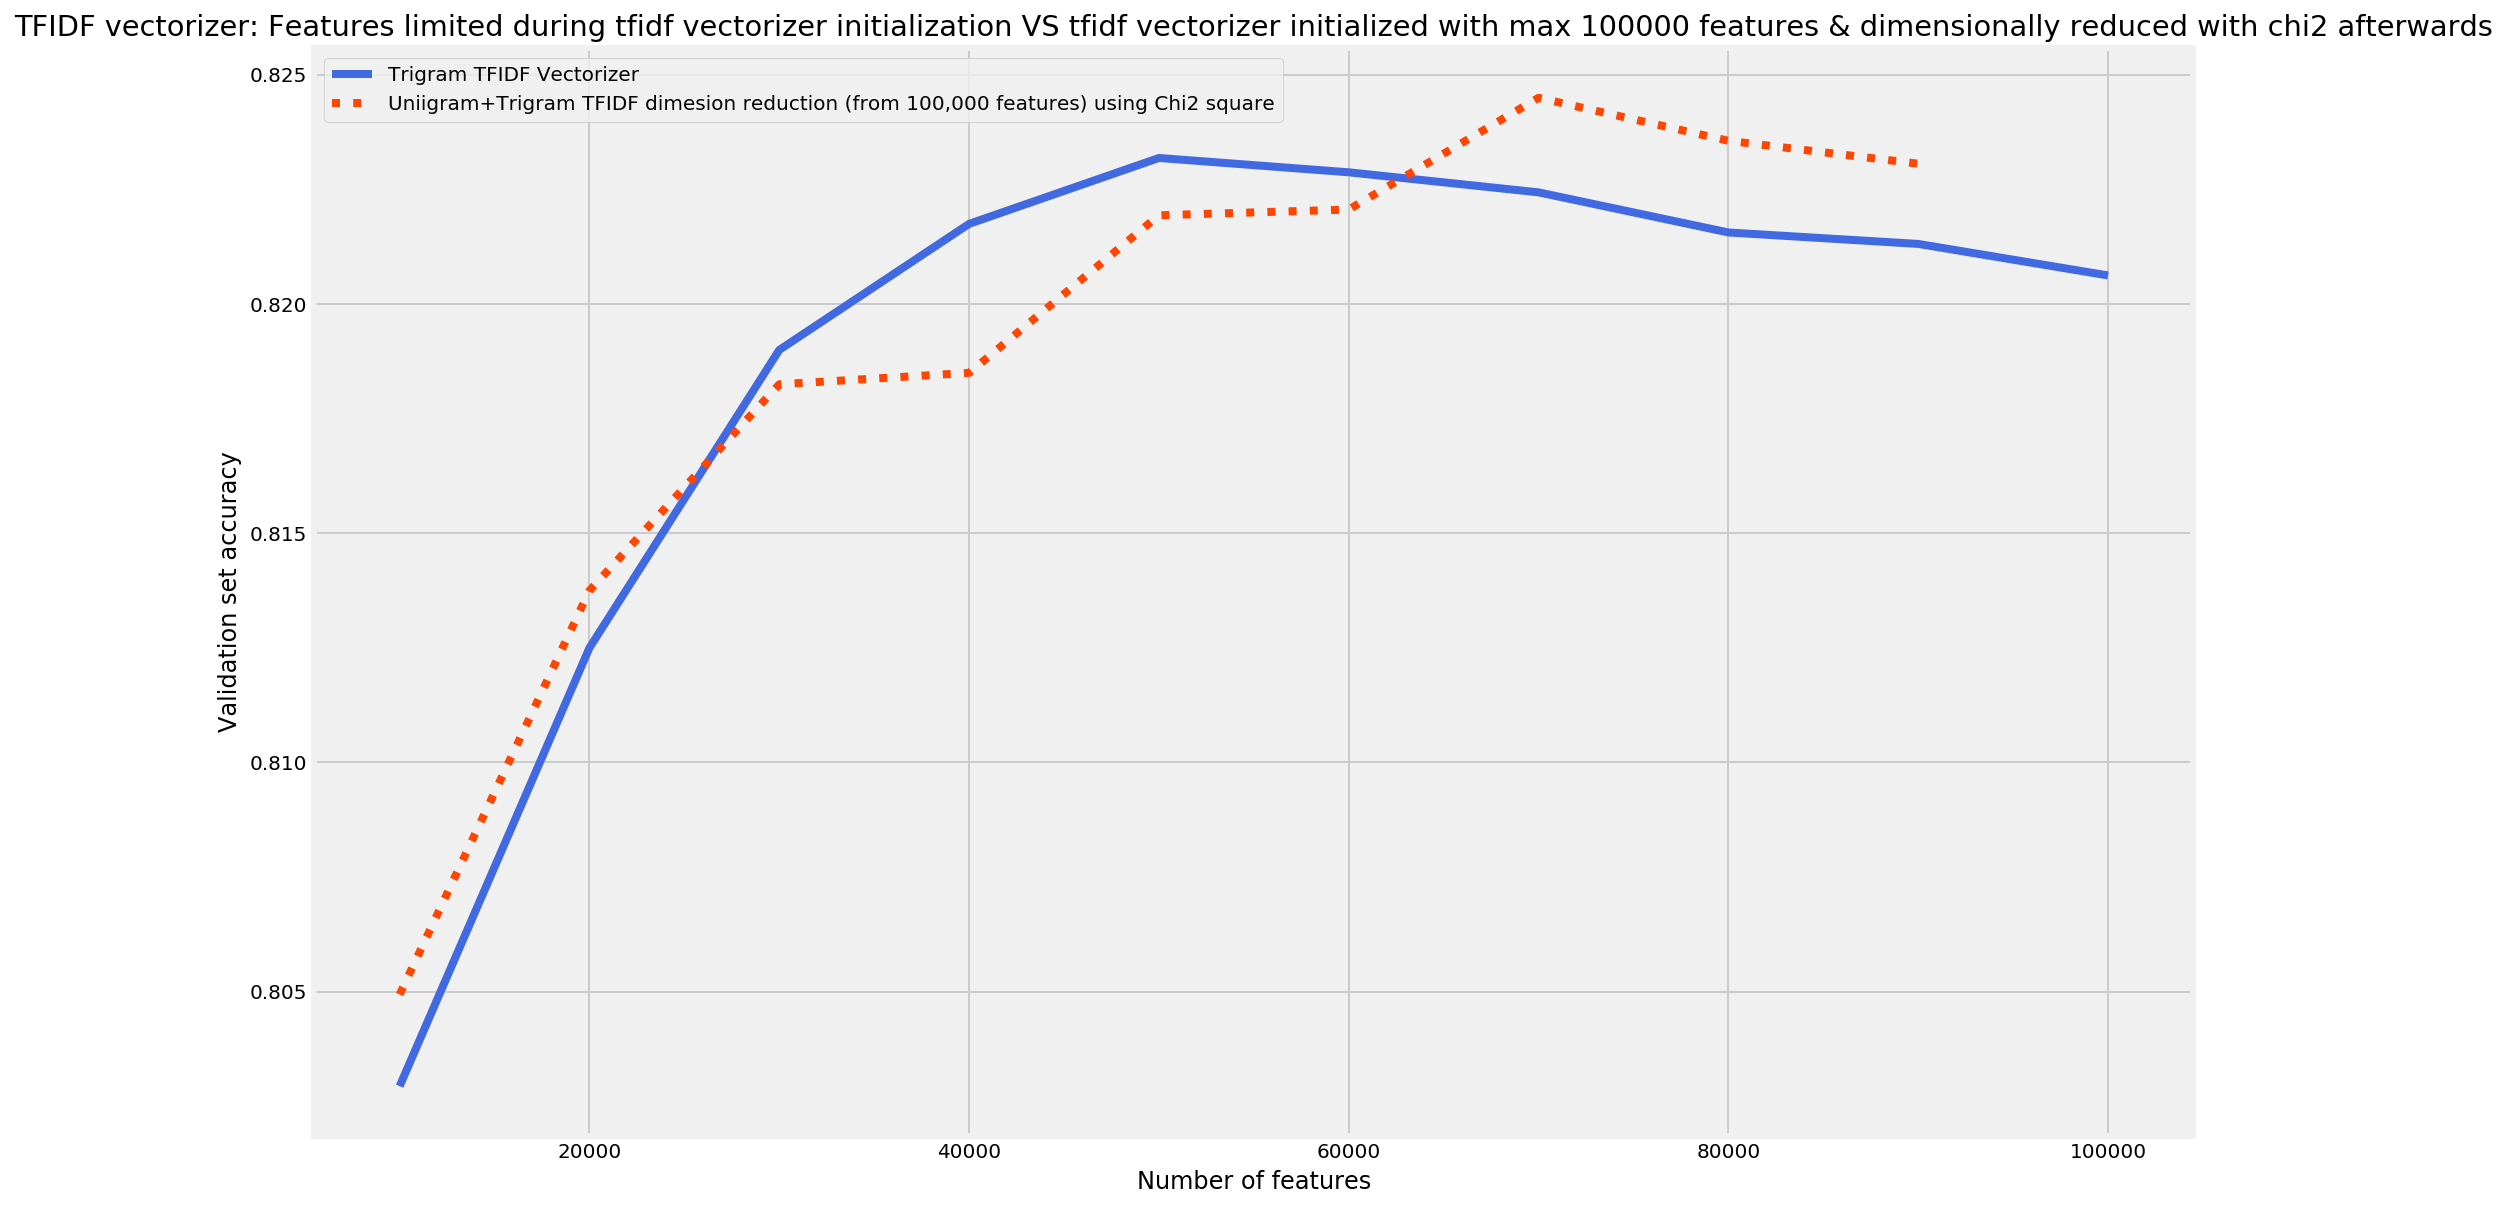

In [24]:
# Plot Important chi2square features after reducing dimesions

plt.figure(figsize=(15,10))

plt.plot(fdf.features, fdf.features_accuracy, label='Trigram TFIDF Vectorizer', color='royalblue')
plt.plot(np.arange(10000, 100000, 10000), ch2_result, label='Uniigram+Trigram TFIDF dimesion reduction (from 100,000 features) using Chi2 square', linestyle=':', color='orangered')

plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")

plt.title("TFIDF vectorizer: Features limited during tfidf vectorizer initialization VS tfidf vectorizer initialized with max 100000 features & dimensionally reduced with chi2 afterwards")
plt.legend()

### Principal Component Analysis

PCA transforms the coordinate system in such a way that the resultant principal component axes describe the data in more concise, informative way.

![title](images/pca.png)

The first Principal Component explains the most variance in the data. In figure B, we see that by drawing the line "Component 1", it is able to retain a lot of information about the dispersed data points.

The second Principal Component "Component 2" explains the second most variance in the data.

The next step is to transform the original data onto our new found pca 2D axes. The final result in figure C gives us a pretty good idea of how the data is redistributed on 2D space even after discarding the third dimension.

Eigenvectors & Eigenvalues are used while implementing above transformations on the data. 

An Eigenvector specifies a direction relative to the original coordinate space, while Eigenvalues indicate the magnitude or amount of variance in the direction of its corresponding Eigenvector.

Blogs to deep dive futher into the concept of PCA

- http://mengnote.blogspot.co.uk/2013/05/an-intuitive-explanation-of-pca.html

- A blog post by Victor Powell: "Principal Component Analysis" (You can manipulate and play around with data points in 2d or 3d that will help you enormously to have an intuitive understanding of what PCA does) http://setosa.io/ev/principal-component-analysis/

- A blog post by George Dallas: "Principal Component Analysis 4 Dummies: Eigenvectors, Eigenvalues and Dimension Reduction" (he has successfully explained the concept without a single math formula, unbelievable) https://georgemdallas.wordpress.com/2013/10/30/principal-component-analysis-4-dummies-eigenvectors-eigenvalues-and-dimension-reduction/

Next, let's try to reduce dimensions of doc2vec vectors with PCA. We can also plot the result on a graph and see if it make sense to reduce the number of features into a smaller set of principal components and how much a given number of principal components with higher variance, can explain about the original features.

In [14]:
# Scaling inputs

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Scaling train and val sets
train_vecs_dbow_dmm_scaled = scaler.fit_transform(train_vecs_dbow_dmm)
val_vecs_dbow_dmm_scaled = scaler.fit_transform(val_vecs_dbow_dmm)

In [15]:
# PCA Decomposition

from sklearn.decomposition import PCA

pca = PCA().fit(train_vecs_dbow_dmm_scaled)

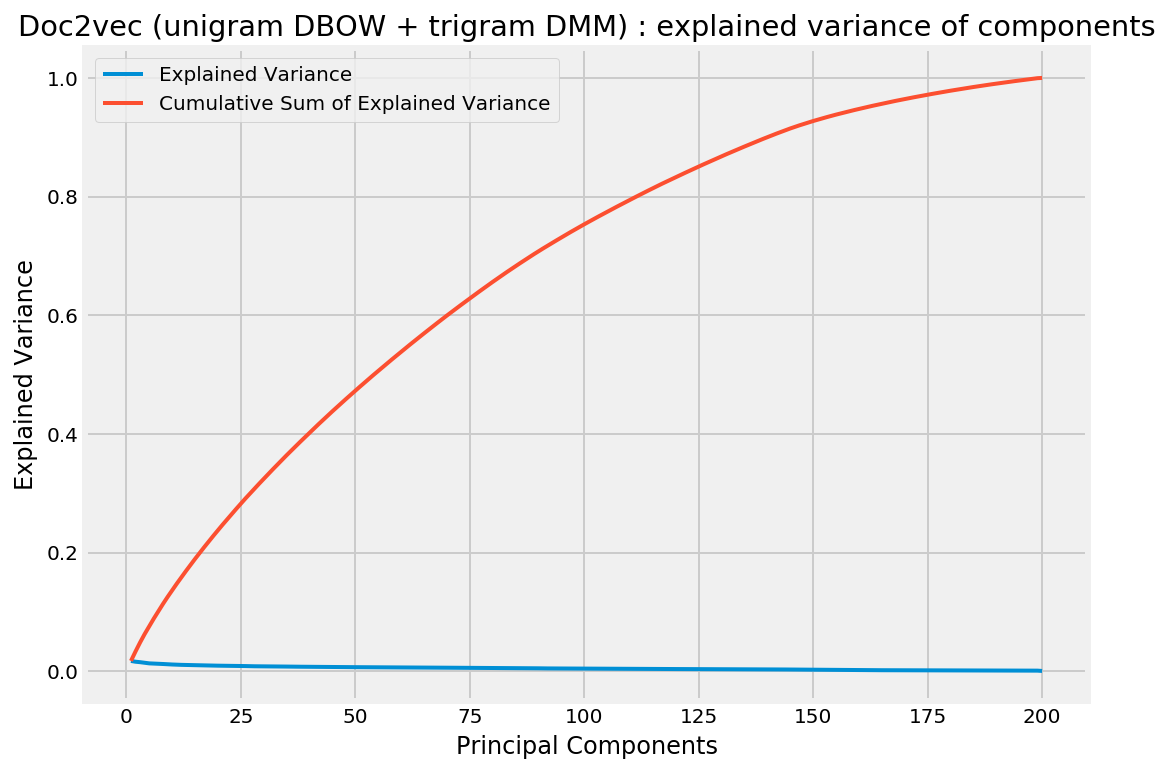

In [17]:
# Plot PCA on 2D

fig, ax = plt.subplots(figsize=(8,6))

pca_components = range(1, pca.n_components_+1)

ax.plot(pca_components, pca.explained_variance_ratio_, lw=2, label='Explained Variance')
ax.plot(pca_components, np.cumsum(pca.explained_variance_ratio_), lw=2, label='Cumulative Sum of Explained Variance')

ax.set_xlabel('Principal Components')
ax.set_ylabel('Explained Variance')
ax.set_title('Doc2vec (unigram DBOW + trigram DMM) : explained variance of components')

plt.legend()
plt.show()

In the above graph, the red line represents the cumulative sum of explained variance and the blue line represents the explained variance of each principal component. 

By looking at the graph above, even though the red line is not perfectly linear, but very close to a straight line. Is this good? No. This means each of the principal components contributes to the variance explanation almost equally and there's no point in reducing the dimensions based on PCA. This can also be seen from the blue line, which is very close to a straight line in the bottom.

In [18]:
del val_vecs_dbow_dmm_scaled